In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.preprocessing import StandardScaler
import numpy as np 
from pathlib import Path
import logging
from pathlib import Path
import sys
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.preprocessing import RobustScaler

PROJECT_ROOT = Path.cwd().parent
sys.path.append(str(PROJECT_ROOT))

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

DATA_DIR = PROJECT_ROOT / "data" / "processed"

#### Load preprocessed data

In [2]:
# Define path
EVENTS_PROPS_FILE = DATA_DIR / "events_with_properties.csv"
USER_FEATS_FILE = DATA_DIR / "user_features.csv"
TRANSACTION = DATA_DIR / "transactions.csv"


In [3]:
def load(path):
    logging.info("Loading from %s", path)
    df = pd.read_csv(path)
    if 'timestamp'in df.columns:
        df['timestamp'] = pd.to_datetime(df['timestamp'])
    if 'first_event'in df.columns:
        df['first_event'] = pd.to_datetime(df['first_event'])
    if 'last_event'in df.columns:
        df['last_event'] = pd.to_datetime(df['last_event'])
    return df

events = load(EVENTS_PROPS_FILE)
user_feats = load(USER_FEATS_FILE)
tx_df = load(TRANSACTION)

In [4]:
tx_money = tx_df.groupby(['visitorid','transactionid'], dropna=False).agg(
        monetary=('price','sum'),
        time = ('timestamp', 'max')
        ).reset_index()

#### BUILD RFM

In [5]:
#-- Build RFM ---
# build features
obs_date = events['timestamp'].max() - pd.Timedelta(days=1)
rfm = tx_money.groupby('visitorid').agg(
    frequency = (
        'transactionid' if 'transactionid' in tx_money.columns else 'monetary', 
        lambda s: s.shape[0] if 'transactionid' in tx_money.columns else (s>0).sum()
    ),
    monetary_avg = ('monetary', 'mean'),
    monetary_sum=('monetary', 'sum'),
    last_purchase = ('time', 'max'),
    first_purchase = ('time', 'min'),
).reset_index()

rfm['recency_days'] = (obs_date - rfm['last_purchase']).dt.days
rfm['tenure_days']  = (obs_date - rfm['first_purchase']).dt.days
rfm['purchase_rate'] = rfm['frequency'] / rfm['tenure_days'].clip(lower=1)
rfm['monetary_rate'] = rfm['monetary_sum'] / rfm['tenure_days'].clip(lower=1)



In [6]:
rfm2 = rfm.copy()
rfm2['monetary_avg_log'] = np.log1p(rfm2['monetary_avg'].fillna(0))
rfm2['frequency_log'] = np.log1p(rfm2['frequency'].fillna(0))
rfm2['recency_days_log'] = np.log1p(rfm2['recency_days'].fillna(0))
rfm2 = rfm2[rfm2['frequency']>1]
cluster_features = rfm2[
    ['recency_days_log','frequency_log','monetary_avg_log']
].replace([np.inf, -np.inf], np.nan).fillna(0)



C:\Users\Acer\AppData\Roaming\Python\Python312\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [7]:
cluster_features

,recency_days_log,frequency_log,monetary_avg_log
32,4.532599,1.098612,10.694238
40,2.397895,1.098612,11.264323
44,4.204693,1.386294,10.773127
58,4.890349,1.609438,10.872073
71,3.332205,1.098612,10.304978
...,...,...,...
11505,4.406719,1.098612,9.879758
11509,4.077537,1.098612,9.441531
11529,4.836282,1.098612,9.200391
11541,3.637586,1.609438,11.469924


#### Compare models: GMM vs KNN

In [8]:
def compare_model(X,k_range=range(2, 11),scaler=None,random_state=42):
    if scaler is not None:
        X_use = scaler.fit_transform(X)
    else:
        X_use = X
    results = []
    for k in k_range:
        kmeans = KMeans(
            n_clusters=k,
            n_init=10,
            random_state=random_state
        )
        labels_km = kmeans.fit_predict(X_use)

        results.append({
            "model": "KMeans",
            "k": k,
            "silhouette": silhouette_score(X_use, labels_km)
        })
        gmm = GaussianMixture(
            n_components=k,
            covariance_type="full",
            random_state=random_state
        )
        labels_gmm = gmm.fit_predict(X_use)
        results.append({
            "model": "GMM",
            "k": k,
            "silhouette": silhouette_score(X_use, labels_gmm)
        })
    results_df = pd.DataFrame(results)
    pivot_df = results_df.pivot(
        index="k",
        columns="model",
        values="silhouette"
    )
    print(pivot_df)
    return results_df, pivot_df


In [9]:
scaler = StandardScaler()
results_df, pivot_df = compare_model(X = cluster_features, scaler = scaler)

model       GMM    KMeans
k                        
2      0.227412  0.518380
3      0.118599  0.347724
4      0.003639  0.395766
5      0.163711  0.319674
6     -0.032392  0.321131
7      0.014738  0.328260
8      0.069656  0.337582
9      0.045270  0.339383
10     0.051842  0.319503


In [10]:
from sklearn.utils import resample
from sklearn.metrics import silhouette_score, adjusted_rand_score
def segmentation_(X,rfm_df,model_type="gmm", n_clusters=4,covariance_type='full',random_state=42,tsne_perplexity=25,tsne_alpha=0.7):
    if model_type.lower() == "gmm":
        model = GaussianMixture(
            n_components=int(n_clusters),
            covariance_type=covariance_type,
            random_state=random_state
        )
        labels_1 = model.fit_predict(X)
    elif model_type.lower() == "kmeans":
        model = KMeans(
            n_clusters=int(n_clusters),
            n_init=10,
            random_state=random_state
        )
        labels_1 = model.fit_predict(X)
    # 2. Stability (Bootstrap + ARI)
    X_boot, idx = resample(
        X,
        np.arange(len(X)),
        replace=True,
        random_state=random_state
    )
    labels_2 = model.fit_predict(X_boot)
    ari = adjusted_rand_score(labels_1[idx], labels_2)
    silhouette = silhouette_score(X, labels_1)

    # Assign segment
    rfm_df = rfm_df.copy()
    rfm_df[f'segment_{model_type}'] = labels_1
    tsne = TSNE(
        n_components=2,
        perplexity=tsne_perplexity,
        learning_rate='auto',
        init='pca',
        random_state=random_state
    )
    X_tsne = tsne.fit_transform(X)
    plt.figure(figsize=(8, 6))
    plt.scatter(
        X_tsne[:, 0],
        X_tsne[:, 1],
        c=rfm_df[f'segment_{model_type}'],
        s=20,
        alpha=tsne_alpha
    )
    plt.colorbar(label="Cluster")
    plt.title("Customer Segmentation (GMM + t-SNE)", fontsize=14)
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.show()
    metrics = {
        "silhouette": silhouette,
        "stability_ARI": ari
    }
    print(f"Silhouette Score : {silhouette:.4f}")
    print(f"Stability (ARI)  : {ari:.4f}")
    return rfm_df, metrics, model


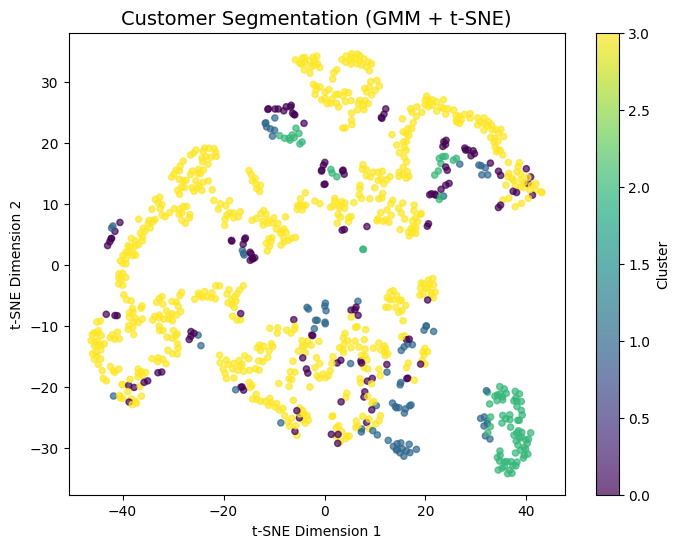

Silhouette Score : 0.0672
Stability (ARI)  : 0.9981


In [11]:
rfm_gmm, gmm_metrics, gmm = segmentation_(X = cluster_features, rfm_df = rfm2, model_type = 'gmm', n_clusters = 4)

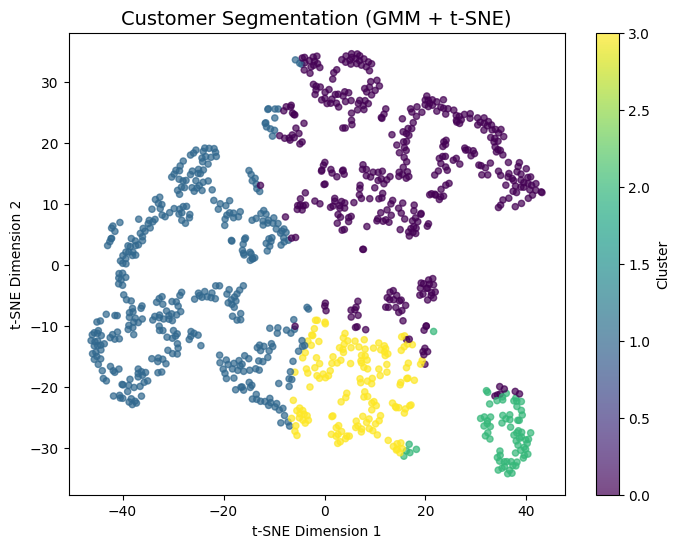

Silhouette Score : 0.4088
Stability (ARI)  : 0.8909


In [12]:
rfm_both, km_metrics, kmeans = segmentation_(X = cluster_features, rfm_df = rfm_gmm, model_type = 'kmeans', n_clusters = 4)

#### Map segment name to the segment

In [13]:
def build_segment_profile(
    df,
    segment_col,
    customer_col='visitorid',
    recency_col='recency_days',
    frequency_col='frequency',
    monetary_avg_col='monetary_avg',
    monetary_sum_col='monetary_sum',
    purchase_rate_col='purchase_rate',
    tenure_col='tenure_days',
    sort_by='total_revenue',
    ascending=False
):
    profile = (
        df
        .groupby(segment_col)
        .agg(
            customers=(customer_col, 'count'),
            avg_recency=(recency_col, 'mean'),
            avg_frequency=(frequency_col, 'mean'),
            avg_monetary=(monetary_avg_col, 'mean'),
            avg_purchase_rate=(purchase_rate_col, 'mean'),
            avg_tenure=(tenure_col, 'mean'),
            total_revenue=(monetary_sum_col, 'sum')
        )
    )
    profile['revenue_share'] = (
        profile['total_revenue'] / profile['total_revenue'].sum()
    )

    quantile_70 = profile['avg_monetary'].quantile(0.7)
    def business_label(row):
        if row.avg_frequency == 1:
            return 'One-time Buyers'
        if (
            row.avg_recency < 30
            and row.avg_frequency > 5
            and row.avg_monetary > quantile_70
        ):
            return 'Champions'
        if row.avg_recency < 60 and row.avg_frequency > 4:
            return 'Loyal Customers'
        if row.avg_recency > 65 and row.avg_frequency <= 2:
            return 'At Risk'
        return 'Potential Loyalists'
    profile = profile.sort_values(sort_by, ascending=ascending)
    profile['business_label'] = profile.apply(business_label, axis=1)
    return profile


In [14]:
gmm_profile = build_segment_profile(rfm_both, 'segment_gmm')
gmm_profile

,customers,avg_recency,avg_frequency,avg_monetary,avg_purchase_rate,avg_tenure,total_revenue,revenue_share,business_label
segment_gmm,,,,,,,,,
2,92,82.510870,31.119565,149739.094014,0.357801,97.336957,4.167913e+08,0.417496,Potential Loyalists
1,80,37.287500,19.737500,182740.551218,0.685507,78.300000,2.759798e+08,0.276446,Loyal Customers
3,730,69.316438,2.000000,158475.736011,0.070807,76.197260,2.313746e+08,0.231765,At Risk
0,129,61.279070,3.000000,191647.590870,0.116950,77.093023,7.416762e+07,0.074293,Potential Loyalists


In [15]:
kmeans_profile = build_segment_profile(rfm_both, 'segment_kmeans')
kmeans_profile

,customers,avg_recency,avg_frequency,avg_monetary,avg_purchase_rate,avg_tenure,total_revenue,revenue_share,business_label
segment_kmeans,,,,,,,,,
2,73,69.794521,49.123288,162131.489373,0.684725,91.520548,5.557237e+08,0.556663,Potential Loyalists
0,408,79.536765,2.551471,282585.680587,0.033624,89.477941,2.803476e+08,0.280821,Potential Loyalists
3,149,8.530201,5.040268,182839.024632,0.509771,31.838926,1.289341e+08,0.129152,Loyal Customers
1,401,75.468828,2.271820,35988.768536,0.037093,81.935162,3.330787e+07,0.033364,Potential Loyalists


In [16]:
def plot_segment_analysis(
    profile_df,
    revenue_col='total_revenue',
    revenue_share_col='revenue_share',
    customer_col='customers',
    radar_metrics=None,
    normalize=True,
    figsize_bar=(8, 5),
    figsize_radar=(6, 6)
):

    profile_sorted = profile_df.sort_values(revenue_col, ascending=False)

    plt.figure(figsize=figsize_bar)
    plt.bar(
        profile_sorted.index.astype(str),
        profile_sorted[revenue_share_col]
    )
    plt.title("Revenue Contribution by Customer Segment")
    plt.xlabel("Segment")
    plt.ylabel("Revenue Share")
    plt.show()

    plt.figure(figsize=figsize_bar)
    plt.bar(
        profile_sorted.index.astype(str),
        profile_sorted[customer_col]
    )
    plt.title("Number of Customers per Segment")
    plt.xlabel("Segment")
    plt.ylabel("Customers")
    plt.show()
    
    if radar_metrics is not None:
        radar_data = profile_df[radar_metrics].copy()

        if normalize:
            radar_data = (
                radar_data - radar_data.min()
            ) / (radar_data.max() - radar_data.min())

        angles = np.linspace(
            0, 2 * np.pi, len(radar_metrics), endpoint=False
        ).tolist()
        angles += angles[:1]

        plt.figure(figsize=figsize_radar)

        for idx, row in radar_data.iterrows():
            values = row.tolist()
            values += values[:1]
            plt.plot(angles, values, label=f"Segment {idx}")
            plt.fill(angles, values, alpha=0.1)

        plt.xticks(angles[:-1], radar_metrics)
        plt.title("Customer Segment Profiles (Normalized)")
        plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
        plt.show()


In [17]:
def plot_segment_scatter(
    df,
    segment_col,
    recency_col='recency_days',
    frequency_col='frequency',
    monetary_col='monetary_avg',
    invert_recency=True,
    alpha=0.6,
    figsize=(7, 5)
):

    plt.figure(figsize=figsize)
    plt.scatter(
        df[recency_col],
        df[frequency_col],
        c=df[segment_col],
        alpha=alpha
    )

    if invert_recency:
        plt.gca().invert_xaxis()

    plt.xlabel("Recency (days)")
    plt.ylabel("Frequency")
    plt.title(f'Recency vs Frequency by {segment_col} ')
    plt.colorbar(label="Segment")
    plt.show()

    plt.figure(figsize=figsize)
    plt.scatter(
        df[frequency_col],
        df[monetary_col],
        c=df[segment_col],
        alpha=alpha
    )
    plt.xlabel("Frequency")
    plt.ylabel("Average Monetary Value")
    plt.title(f'Frequency vs Monetary by {segment_col}')
    plt.colorbar(label="Segment")
    plt.show()


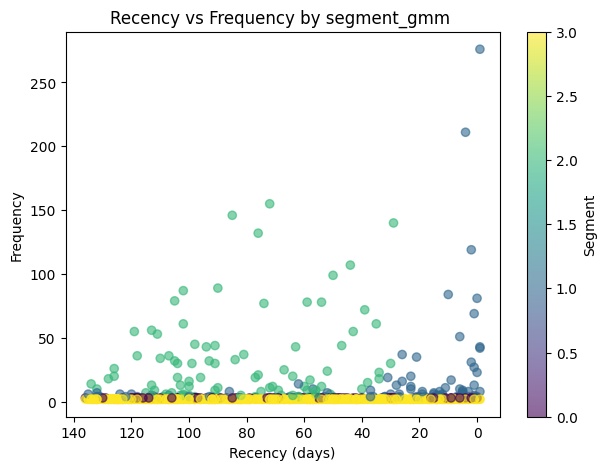

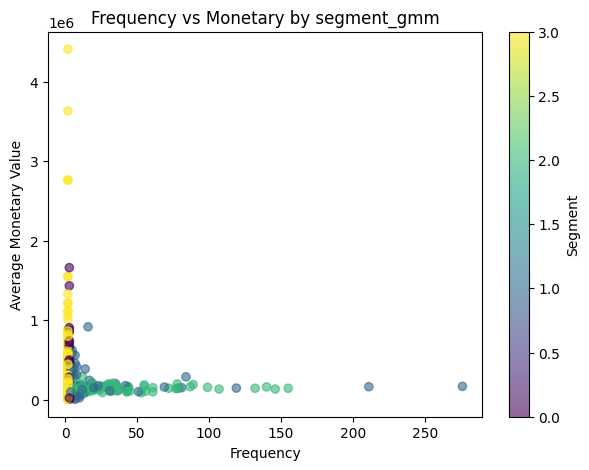

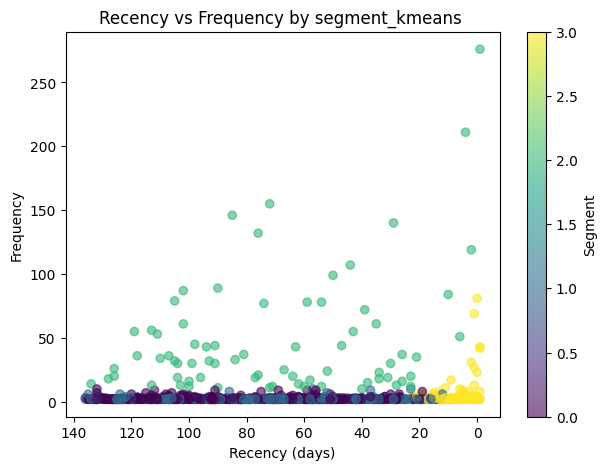

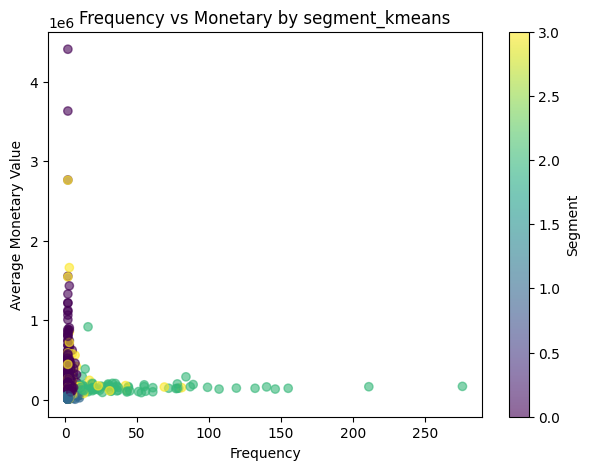

In [18]:
plot_segment_scatter(
    df=rfm_both,
    segment_col='segment_gmm'
)
plot_segment_scatter(
    df=rfm_both,
    segment_col='segment_kmeans'
)

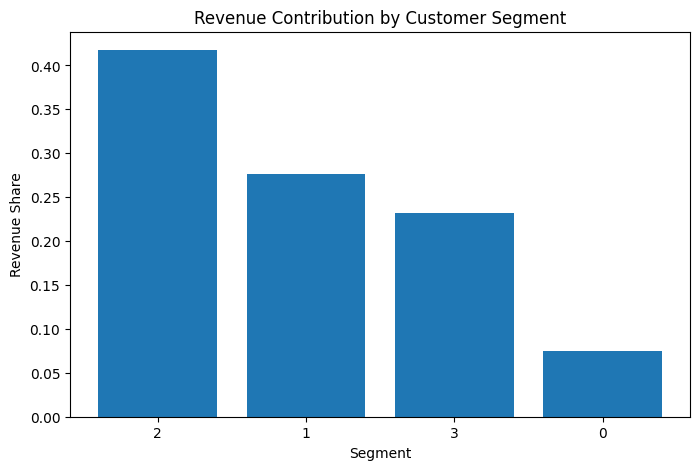

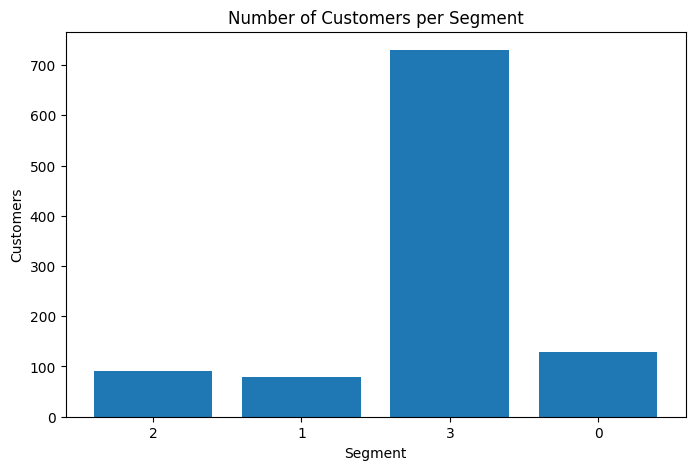

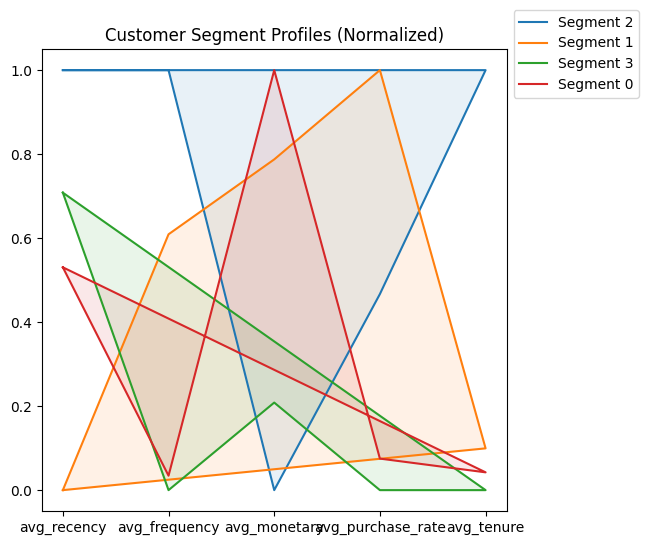

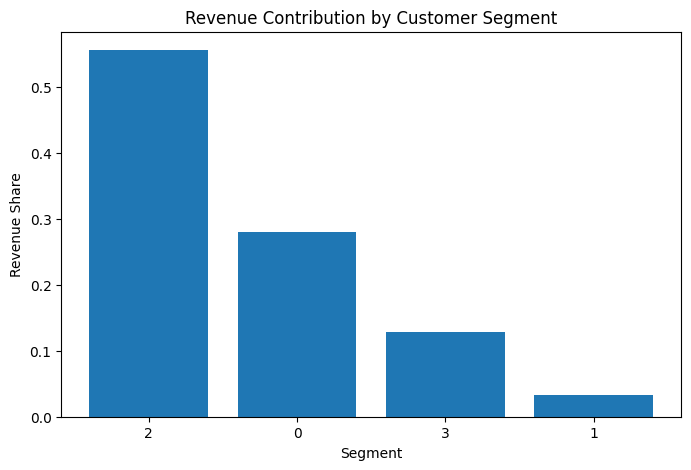

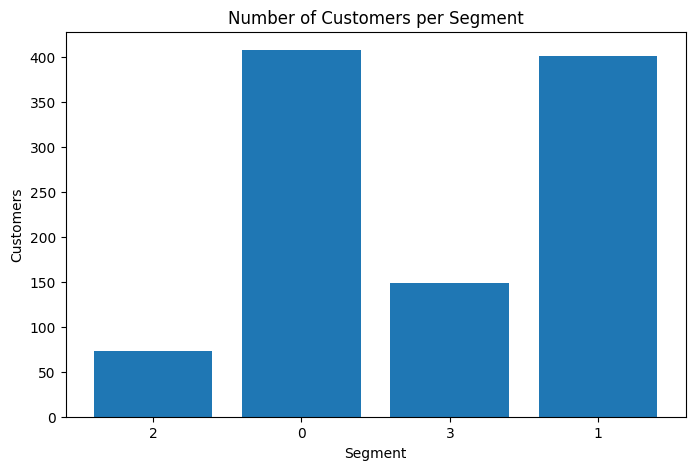

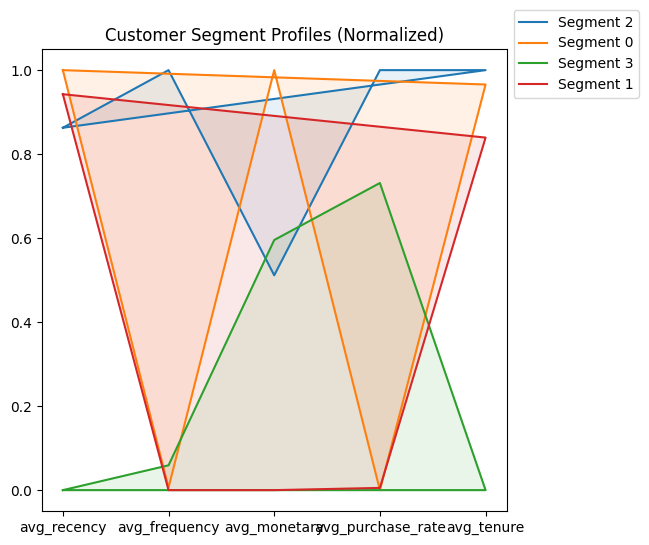

In [19]:
radar_metrics = [
    'avg_recency',
    'avg_frequency',
    'avg_monetary',
    'avg_purchase_rate',
    'avg_tenure'
]

plot_segment_analysis(
    profile_df=gmm_profile,
    radar_metrics=radar_metrics
)
plot_segment_analysis(
    profile_df = kmeans_profile, 
    radar_metrics = radar_metrics
)


#### SAVE FOR THE FUTURE PIPELINE

In [20]:
# save for the future pipeline
segment_to_label = gmm_profile['business_label']
rfm = rfm.copy()
rfm['business_label'] = rfm_both['segment_gmm'].map(segment_to_label)

eligible_rfm = rfm[
    (rfm['business_label'] != 'One-time Buyers') &
    (rfm['frequency'] > 1)
][['visitorid', 'business_label']]


user_feats_clean = user_feats.merge(
    eligible_rfm,
    on='visitorid',
    how='inner'   
)
user_feats_clean.to_csv(DATA_DIR / "users_pipeline.csv", index = False)

In [21]:
user_feats_clean['business_label'].value_counts()

business_label
At Risk                730
Potential Loyalists    221
Loyal Customers         80
Name: count, dtype: int64